### 1. Encoding Documents 

Documentation : https://www.sbert.net/

In [1]:
from sentence_transformers import SentenceTransformer,util
import numpy as np
import torch

In [2]:
model_id = 'thenlper/gte-base'
#model_id = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_id)

In [3]:
sents = [
    'He went to the bank to retrieve cash.',
    'He was resting by the bank in the evening',
    'He went to the ATM to get some money.'
]

#### 1.1 Embedding

In [4]:
embeds = model.encode(sentences=sents)

In [5]:
type(embeds),embeds.shape

(numpy.ndarray, (3, 768))

#### 1.2 Obtaining Cosine Similarity

In [6]:
cos_sim = util.cos_sim(embeds[0],embeds[1])
print(f'Cosine Similarity between two sentences : {cos_sim.squeeze().tolist():0.6f}')

Cosine Similarity between two sentences : 0.894105


In [7]:
cos_sim = util.cos_sim(embeds[1],embeds[2])
print(f'Cosine Similarity between two sentences : {cos_sim.squeeze().tolist():0.6f}')

Cosine Similarity between two sentences : 0.875534


### 2.0 Similarity Matrix

In [8]:
sentences = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.'
          ]

In [9]:
embeds = model.encode(sentences)
cos_sim = util.cos_sim(embeds,embeds)

In [10]:
cos_sim.shape

torch.Size([9, 9])

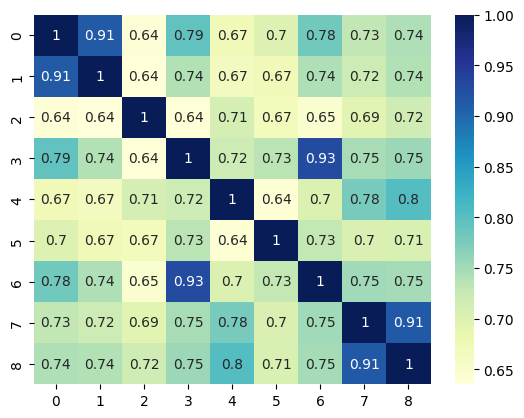

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cos_sim.numpy(), annot=True, cmap="YlGnBu")
plt.show()

#### 2.1 Ranking based on Similarity Scores

In [12]:
# Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim) - 1):
    for j in range(i + 1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

In [13]:
# Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

In [14]:
print("Top-5 most similar pairs :\n")
for score, i, j in all_sentence_combinations[0:5]:
    print(f"'{sentences[i]}' | '{sentences[j]}'\ncosine score: {cos_sim[i][j]}\n")

Top-5 most similar pairs :

'A man is riding a horse.' | 'A man is riding a white horse on an enclosed ground.'
cosine score: 0.9293339252471924

'A monkey is playing drums.' | 'Someone in a gorilla costume is playing a set of drums.'
cosine score: 0.9137171506881714

'A man is eating food.' | 'A man is eating a piece of bread.'
cosine score: 0.9129796028137207

'A woman is playing violin.' | 'Someone in a gorilla costume is playing a set of drums.'
cosine score: 0.8039714097976685

'A man is eating food.' | 'A man is riding a horse.'
cosine score: 0.7934727072715759



### 3.0 Semantic Search

In [15]:
que = "What is semantic search?"
ans1 = 'Semantic search denotes search with meaning, as distinguished from lexical search where the search engine looks for literal matches of the query words or variants of them, without understanding the overall meaning of the query.'
ans2 = "Semantic search seeks to improve search accuracy by understanding the searcher's intent and the contextual meaning of terms as they appear in the searchable dataspace"
ans3 = "Vector search is numeric representation of data and related context, stored in high dimensional (dense) vectors."

In [16]:
query_embedding = model.encode(que)
corpus_embeddings = model.encode([ans1, ans2, ans3])

In [17]:
type(corpus_embeddings.shape[0])

int

In [18]:
results = util.semantic_search(query_embedding, corpus_embeddings)

In [19]:
for i in results:
    for j in i:
        print('Semantic Similarity between question and answer{} : {}'.format(j['corpus_id'],j['score']))

Semantic Similarity between question and answer0 : 0.9572983384132385
Semantic Similarity between question and answer1 : 0.9321224689483643
Semantic Similarity between question and answer2 : 0.8509876132011414


In [20]:
from transformers import pipeline


qa_model = pipeline(model ='distilbert/distilbert-base-cased-distilled-squad' ,task = "question-answering")
qa_model(question = que, context = ans1)

{'score': 0.5898793339729309, 'start': 36, 'end': 43, 'answer': 'meaning'}

### 4.0 Clustering

Use : To sort documents

In [21]:
docs = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.'
          ]

In [22]:
model_id = 'thenlper/gte-base'
#model_id = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_id)

In [23]:
from sklearn.cluster import KMeans
import numpy as np

embeds = model.encode(sentences= docs)

In [24]:
embeds.shape

(9, 768)

In [25]:
# Normalize the embeddings to unit length
corpus_embeddings = embeds/  np.linalg.norm(embeds, axis=1, keepdims=True)

In [26]:
corpus_embeddings.shape

(9, 768)

In [ ]:
clustering_model = KMeans(n_clusters=3)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [28]:
print(cluster_assignment)

[2 2 1 0 1 0 0 1 1]


In [29]:
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(sentences[sentence_id])
clustered_sentences

{2: ['A man is eating food.', 'A man is eating a piece of bread.'],
 1: ['The girl is carrying a baby.',
  'A woman is playing violin.',
  'A monkey is playing drums.',
  'Someone in a gorilla costume is playing a set of drums.'],
 0: ['A man is riding a horse.',
  'Two men pushed carts through the woods.',
  'A man is riding a white horse on an enclosed ground.']}

In [30]:
x = corpus_embeddings
y = clustering_model.predict(corpus_embeddings)

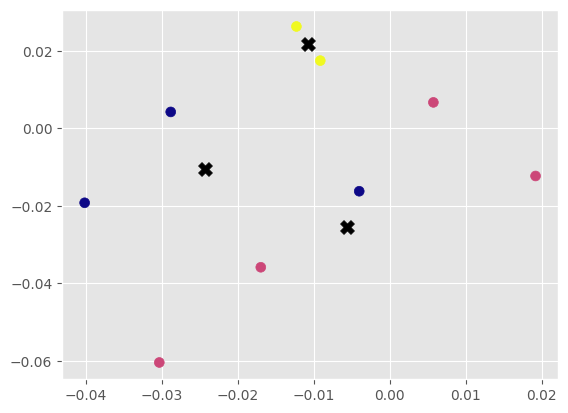

In [31]:
plt.style.use('ggplot')
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='plasma')
centers = clustering_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black',marker='X', s=100, alpha=1);